# **Task 7: Basic Machine Learning with Random Forests:**
This example of machine learning will lead you through one of the example of using the decision tree and regression to estimate redshifts of objects like galaxies and quasars in a field with only photometric parameters.

Install the following require packages:

*   sklearn (sci-kit learn; possibly already installed with Anaconda)
*   astroML
*   astropy



In [1]:
"""
!pip install astropy
!pip install astroML
"""

# For online participants, installing needed Python packages

'\n!pip install astropy\n!pip install astroML\n'

Let's call in our usual suspects (i.e. import normally used packages)


*   NumPy
*   SciPy
*   Matplotlib.Pyplot
*   AstroML
*   sklearn



In [2]:
import numpy as np
from urllib.error import HTTPError
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor #import both classes of Random Forest: classifier and regressor
from astroML.datasets import fetch_sdss_specgals, fetch_sdss_spectrum
from astroML.utils.decorators import pickle_results

import pandas as pd

#**Block 7.1:**
Now, let's read in some (useful) photometric parameters from the table along with the spectroscopic parameters we are trying to estimate (i.e., the redhift).

In [3]:
data_file_path = 'data/table_dr17_galaxy_sample_rf.csv' # check what is the correct path here
'''objID, ra, dec, specz, photoz, up, gp, rp, ip, zp, rad_up, rad_gp, rad_rp, rad_ip, rad_zp = \
  np.loadtxt(data_file_path, usecols=(0,1,2,15,16,32,33,34,35,36,37,38,39,40,41), unpack=False, skiprows=0, delimiter=',')'''
df = pd.read_csv(data_file_path, usecols=(0,1,2,15,16,32,33,34,35,36,37,38,39,40,41), skiprows=0, delimiter=',', header=0)
# replace df header with new column names
df.columns = ['objID', 'ra', 'dec', 'specz', 'photoz', 'up', 'gp', 'rp', 'ip', 'zp', 'rad_up', 'rad_gp', 'rad_rp', 'rad_ip', 'rad_zp']
df.head()


,objID,ra,dec,specz,photoz,up,gp,rp,ip,zp,rad_up,rad_gp,rad_rp,rad_ip,rad_zp
0,2371243122656045056,164.974421,32.700895,0.118154,0.118076,20.02380,18.29567,17.34548,16.96514,16.81695,2.970322,6.303518,5.913595,5.443686,4.902890
1,11563028194685900800,162.397596,32.822911,0.846894,0.694168,23.41901,22.23428,21.22558,19.91217,19.20969,0.698639,27.915820,2.682886,1.940544,2.662174
2,2371176602202564608,166.849352,32.442179,0.115204,0.128297,20.24776,18.62824,17.83971,17.41854,17.09755,2.196721,2.950055,3.143428,3.208560,3.076317
3,2371297273603713024,166.805393,32.796378,0.152356,0.206094,19.55022,18.62261,17.84364,17.43646,17.07704,6.265349,4.292650,4.238888,3.912683,3.963925
4,2240594199181289472,164.986526,29.801050,0.107137,0.115004,19.69930,18.43018,17.71981,17.40668,17.32325,6.693025,7.219200,6.985210,6.059654,5.251017


In [4]:
objID, ra, dec, specz, photoz, up, gp, rp, ip, zp, rad_up, rad_gp, rad_rp, rad_ip, rad_zp = df.values.T

print(objID.shape, ra.shape, dec.shape, specz.shape, photoz.shape, up.shape, gp.shape, rp.shape, ip.shape, zp.shape, rad_up.shape, rad_gp.shape, rad_rp.shape, rad_ip.shape, rad_zp.shape)

# merge all 5 bands of magnitudes into 1 2D array size = #of object x 5 filters
petro_mag_sample = np.transpose(np.array([up, gp, rp, ip, zp]))
specz_train = specz

print()
print(specz_train.shape, petro_mag_sample.shape)

(50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,) (50210,)

(50210,) (50210, 5)


(array([9559., 9353., 2835., 3807., 6153., 9188., 4383., 2087., 2062.,
         783.]),
 array([1.05548600e-04, 1.00074184e-01, 2.00042819e-01, 3.00011454e-01,
        3.99980089e-01, 4.99948724e-01, 5.99917359e-01, 6.99885995e-01,
        7.99854630e-01, 8.99823265e-01, 9.99791900e-01]),
 <BarContainer object of 10 artists>)

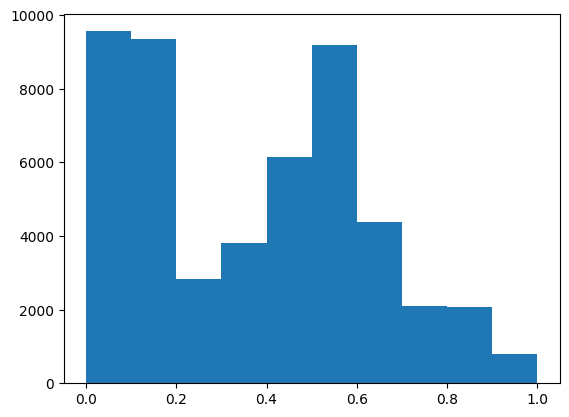

In [5]:
plt.hist(specz,bins=10)

(array([  347.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 49863.]),
 array([-9.99900000e+03, -8.99900030e+03, -7.99900059e+03, -6.99900089e+03,
        -5.99900118e+03, -4.99900148e+03, -3.99900177e+03, -2.99900207e+03,
        -1.99900236e+03, -9.99002659e+02,  9.97046000e-01]),
 <BarContainer object of 10 artists>)

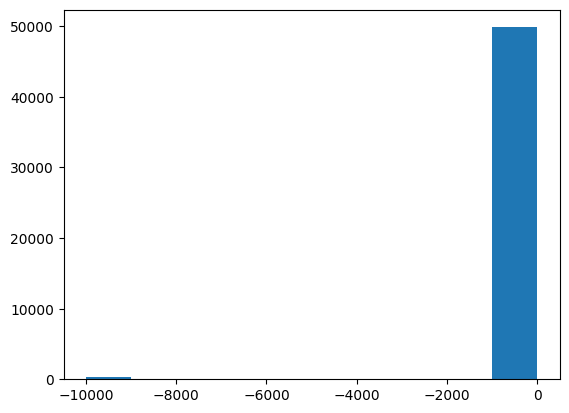

In [6]:
plt.hist(photoz,bins=10)

Now, define a subset (possibly 10%) from the entire sample to be used for the verfication.

In [7]:
# set verification subset to be about 1/10 of the entire dataset
petro_mag_test = petro_mag_sample[::10]
specz_test = specz_train[::10]


print(f'petro_mag_test.shape: {petro_mag_test.shape}')
print(f'specz_test.shape: {specz_test.shape}')

petro_mag_test.shape: (5021, 5)
specz_test.shape: (5021,)


#**Block 7.2:**
Now, we have prepared the sample (petro magnitudes in "ugriz') to be fit with Random Forest Regression.

*   Set up a function with nested "for loop" to test the model RMS as a function of forest "depth"
*   You can use the for loop without the function setting as well.
*   Where "RMS" is the root mean square of the differences between the "predicted redshift" and the actual values.


In [8]:
#------------------------------------------------------------
# Compute the results
# This is a long computation, so we'll save the results to a pickle.

@pickle_results('RandomForest_photoZ.pkl') # Will record anything happen after this statement into ".pkl" file // Can be omitted
def predict_photoz_RF(depth):
    rms_train = np.zeros(len(depth))
    rms_test = np.zeros(len(depth))
    inx_best = 0     # Set the initial best index for the best result depth
    z_fit_best = None # Define an empty variable to be adjusted later

    for i, d in enumerate(depth): # run the for loop through the elements and values of "depth"
        clf = RandomForestRegressor(n_estimators=10, max_depth=d, random_state=0)
        clf.fit(petro_mag_sample, specz_train)

        z_fit_train = clf.predict(petro_mag_sample)
        z_fit_test  = clf.predict(petro_mag_test)
        rms_train[i] = np.average(np.sqrt((z_fit_train - specz_train) ** 2))
        rms_test[i]  = np.average(np.sqrt((z_fit_test - specz_test) ** 2))

        if rms_test[i] <= rms_test[inx_best]:
            inx_best = i
            z_fit_best = z_fit_test

    return rms_test, rms_train, inx_best, z_fit_best


#**Block 7.3: Perfecto!**
Find the best value of depth to use in the model.
This corresponds to the depth that gives the smallest RMS values.  
You may have found that the more the depth value is, the lower the RMS becomes. However, the deeper we go, the more computational expensive it is.

*   Create a comparison diagram between PhotoZ RMS vs. Depth of (1) training set and (2) testing (verifying) set.
*   Choose the lowest value of depth, while the RMS_test < 0.020


@pickle_results: using precomputed results from 'RandomForest_photoZ.pkl'


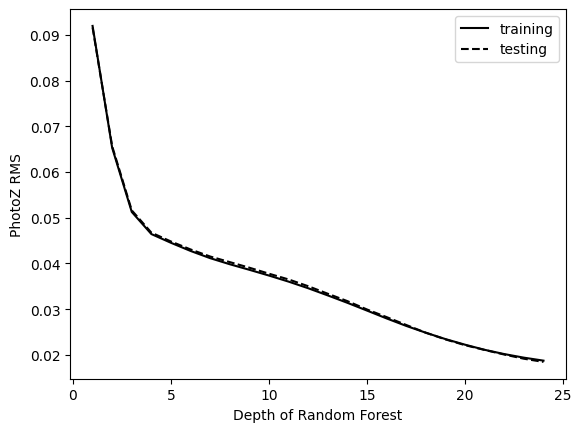

23


In [9]:
# make a array of integer from 1-24
depth_array = np.arange(1, 25)
rms_test, rms_train, inx_best, z_fit_best = predict_photoz_RF(depth_array)

plt.plot(depth_array, rms_train,'k-', label='training')
plt.plot(depth_array, rms_test, 'k--', label='testing')
plt.legend()
plt.ylabel('PhotoZ RMS')
plt.xlabel('Depth of Random Forest')
plt.show()

depth_stop = depth_array[inx_best]
depth_lowest = np.min(depth_array[np.where(rms_test<0.020)])
print(depth_lowest)



Text(0.5, 0, 'SpecZ')

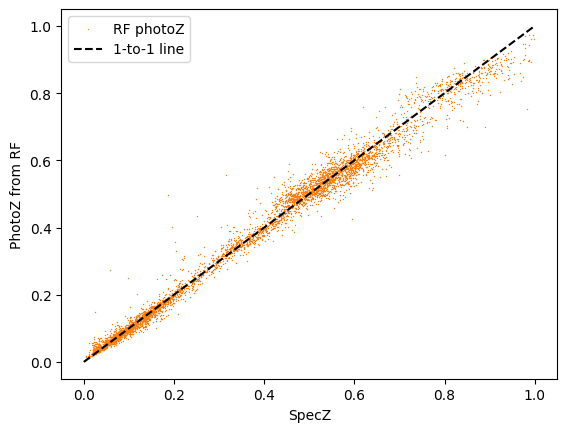

In [10]:
# Make a plot showing the scatter of data points between the "predicted photoZ" and the real "spectroscopic redshift"
plt.scatter(specz_test, z_fit_best, s=1, lw=0, c='C1', label='RF photoZ')
plt.plot([0,1], [0,1],'k--', label='1-to-1 line')
plt.legend()
plt.ylabel('PhotoZ from RF')
plt.xlabel('SpecZ')

#**Block 7.4:**
**"Predicting" PhotoZ and its application**

Download another table which contain the extended sources within 1x1 sq-degree FOV (adjacent field to field containing the training data).
Becareful, this one does not contain any redshift values. So the column number shifted.

*   Apply "RandomForestRegressor" function with depth = depth_lowest.
*   Retrain the function again.
*   Obtain PhotoZ for the targets in this field.






Read in another file (smaller number of sample from the 1x1 sq-degree FOV). This one would contain similar parameters, except redshifts. This will be the one we utilized upon after obtaining the model from the Train and Verification steps.  

In [11]:
data_file_path_target = 'data/table_dr17_all_sources_in_1x1sqdegree.csv' # check what is the correct path here
objID_target, ra_target, dec_target, up_target, gp_target, rp_target, ip_target, zp_target, \
  rad_up_target, rad_gp_target, rad_rp_target, rad_ip_target, rad_zp_target = \
  np.loadtxt(data_file_path_target, usecols=(0,1,2,28,29,30,31,32,33,34,35,36,37), unpack=True, skiprows=1, delimiter=',')

petro_mag_target = np.transpose(np.array([up_target, gp_target, rp_target, ip_target, zp_target]))
print(petro_mag_target, petro_mag_target.shape)

[[23.46063 21.47128 20.80324 22.59081 24.8912 ]
 [22.78403 23.20962 21.88616 21.34362 20.26059]
 [21.85871 20.42323 19.52804 19.25802 18.63177]
 ...
 [23.44507 23.31129 24.50531 21.65801 21.03001]
 [24.32151 21.73574 20.89838 20.40593 21.14495]
 [24.1893  25.20121 21.7543  21.58406 21.26623]] (16515, 5)


In [12]:
clf = RandomForestRegressor(n_estimators=10, max_depth=depth_stop, random_state=0)
clf.fit(petro_mag_sample, specz_train)

photoZ_target = clf.predict(petro_mag_target)

*   Find an overdensity within this field (i.e. looking at the PhotoZ distribution or histogram). Is there a "bump" or "knee"?
*   Plot the distribution along RA and Dec of the sources within that specific redshift range?
*   Can you spot the overdensity (or clustering)?

(array([  5.,   9.,  11.,  18.,  15.,  21.,  20.,  18.,  26.,  19.,  23.,
         21.,  33.,  29.,  45.,  42.,  54.,  35.,  40.,  40.,  35.,  50.,
         29.,  30.,  40.,  38.,  47.,  54.,  34.,  44.,  54.,  56.,  60.,
         58.,  70.,  66.,  59.,  52.,  60.,  64.,  53.,  81.,  66.,  58.,
         69.,  73.,  90., 103., 105., 121., 131.,  98., 139., 131., 116.,
        134., 120., 135.,  96., 121., 105., 125., 131., 120., 150., 146.,
        161., 176., 192., 202., 192., 255., 300., 351., 312., 355., 426.,
        472., 543., 579., 670., 745., 874., 960., 986., 938., 822., 596.,
        423., 263., 183.,  93.,  53.,  27.,  17.,   4.,   2.,   1.,   0.,
          1.]),
 array([0.02154332, 0.03110442, 0.04066553, 0.05022663, 0.05978773,
        0.06934884, 0.07890994, 0.08847105, 0.09803215, 0.10759326,
        0.11715436, 0.12671546, 0.13627657, 0.14583767, 0.15539878,
        0.16495988, 0.17452099, 0.18408209, 0.19364319, 0.2032043 ,
        0.2127654 , 0.22232651, 0.23188761, 0.

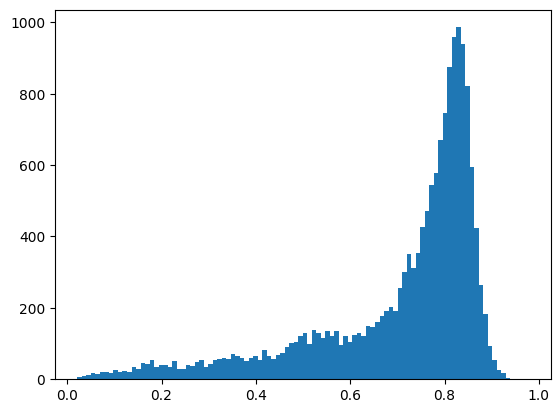

In [13]:
plt.hist(photoZ_target, bins=100)

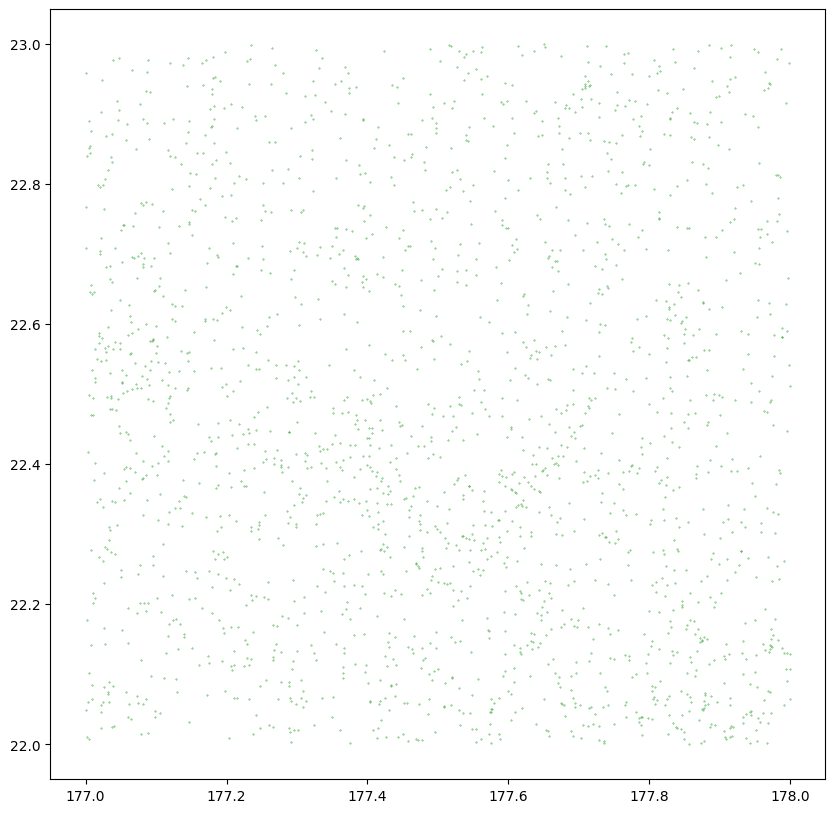

In [14]:
#Spot a knee in the photoZ distribution at around photoZ = 0.5
redshift_slice = np.where((photoZ_target > 0.4) & (photoZ_target < 0.6))
plt.figure(figsize=(10,10))
plt.scatter(ra_target[redshift_slice], dec_target[redshift_slice], s=0.1, color='C2')


# Solving overfitting

(array([  21.,  179.,  692.,  968., 1029., 1218., 1422., 1640., 1499.,
        1400., 1361., 1295., 1195., 1107.,  901.,  779.,  705.,  599.,
         518.,  354.,  342.,  292.,  292.,  285.,  294.,  270.,  243.,
         236.,  224.,  294.,  288.,  289.,  337.,  450.,  520.,  549.,
         551.,  472.,  436.,  391.,  370.,  301.,  334.,  333.,  492.,
         761.,  938.,  964.,  945.,  970., 1106., 1068., 1161., 1203.,
        1204., 1256., 1135., 1022., 1013.,  847.,  786.,  646.,  512.,
         470.,  403.,  389.,  368.,  336.,  283.,  251.,  204.,  199.,
         159.,  156.,  135.,  114.,  115.,  122.,   99.,  101.,   74.,
          62.,   68.,   56.,   64.,   45.,   30.,   36.,   28.,   31.,
          19.,   24.,   30.,   17.,   14.,    9.,   14.,   15.,   10.,
           9.]),
 array([8.6700000e-04, 1.0828790e-02, 2.0790580e-02, 3.0752370e-02,
        4.0714160e-02, 5.0675950e-02, 6.0637740e-02, 7.0599530e-02,
        8.0561320e-02, 9.0523110e-02, 1.0048490e-01, 1.1044669e-01

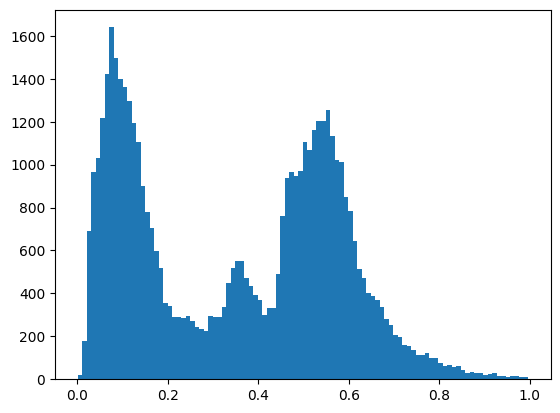

In [15]:
# take out the records of df that have photoZ less than -10
df = df[df['photoz'] > -10]
plt.hist(df['photoz'], bins=100)

In [16]:
objID, ra, dec, specz, photoz, up, gp, rp, ip, zp, rad_up, rad_gp, rad_rp, rad_ip, rad_zp = df.values.T

print(objID.shape, ra.shape, dec.shape, specz.shape, photoz.shape, up.shape, gp.shape, rp.shape, ip.shape, zp.shape, rad_up.shape, rad_gp.shape, rad_rp.shape, rad_ip.shape, rad_zp.shape)

# merge all 5 bands of magnitudes into 1 2D array size = #of object x 5 filters
petro_mag_sample = np.transpose(np.array([up, gp, rp, ip, zp]))
specz_train = specz

print()
print(specz_train.shape, petro_mag_sample.shape)

(49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,) (49863,)

(49863,) (49863, 5)


In [17]:
# split the sample into training and testing sets using the "train_test_split" function from sklearn
# the dataset must have the same number of rows
from sklearn.model_selection import train_test_split
petro_mag_train, petro_mag_test, specz_train, specz_test = train_test_split(petro_mag_sample, specz_train, test_size=0.1, random_state=42)

# print size of training and testing sets
print(f'petro_mag_train.shape: {petro_mag_train.shape}')
print(f'specz_train.shape: {specz_train.shape}')
print(f'petro_mag_test.shape: {petro_mag_test.shape}')
print(f'specz_test.shape: {specz_test.shape}')


petro_mag_train.shape: (44876, 5)
specz_train.shape: (44876,)
petro_mag_test.shape: (4987, 5)
specz_test.shape: (4987,)


In [18]:
#------------------------------------------------------------
# Compute the results
# This is a long computation, so we'll save the results to a pickle.

# This version some data points are removed from the training set

@pickle_results('RandomForest_photoZ1.pkl') # Will record anything happen after this statement into ".pkl" file // Can be omitted
def predict_photoz_RF(depth):
    rms_train = np.zeros(len(depth))
    rms_test = np.zeros(len(depth))
    inx_best = 0     # Set the initial best index for the best result depth
    z_fit_best = None # Define an empty variable to be adjusted later

    for i, d in enumerate(depth): # run the for loop through the elements and values of "depth"
        clf = RandomForestRegressor(n_estimators=10, max_depth=d, random_state=0)
        clf.fit(petro_mag_train, specz_train)

        z_fit_train = clf.predict(petro_mag_train)
        z_fit_test  = clf.predict(petro_mag_test)
        rms_train[i] = np.average(np.sqrt((z_fit_train - specz_train) ** 2))
        rms_test[i]  = np.average(np.sqrt((z_fit_test - specz_test) ** 2))

        if rms_test[i] <= rms_test[inx_best]:
            inx_best = i
            z_fit_best = z_fit_test

    return rms_test, rms_train, inx_best, z_fit_best

@pickle_results: using precomputed results from 'RandomForest_photoZ1.pkl'


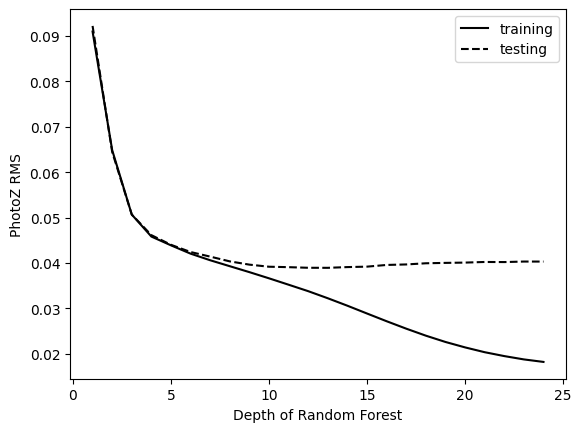

No depth can achieve 0.020 RMS


In [19]:
# make a array of integer from 1-24
depth_array = np.arange(1, 25)
rms_test, rms_train, inx_best, z_fit_best = predict_photoz_RF(depth_array)

plt.plot(depth_array, rms_train,'k-', label='training')
plt.plot(depth_array, rms_test, 'k--', label='testing')
plt.legend()
plt.ylabel('PhotoZ RMS')
plt.xlabel('Depth of Random Forest')
plt.show()

depth_stop = depth_array[inx_best]
try:
    depth_lowest = np.min(depth_array[np.where(rms_test<0.020)])
    print(depth_lowest)
except:
    print('No depth can achieve 0.020 RMS')


Text(0.5, 0, 'SpecZ')

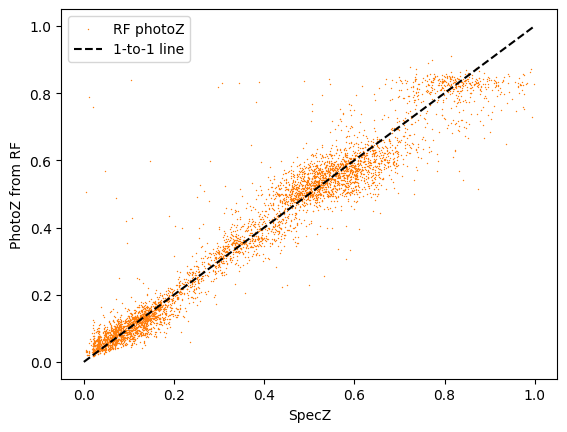

In [20]:
# Make a plot showing the scatter of data points between the "predicted photoZ" and the real "spectroscopic redshift"
plt.scatter(specz_test, z_fit_best, s=1, lw=0, c='C1', label='RF photoZ')
plt.plot([0,1], [0,1],'k--', label='1-to-1 line')
plt.legend()
plt.ylabel('PhotoZ from RF')
plt.xlabel('SpecZ')

## Test with other dataset

In [21]:
data_file_path_target = 'data/table_dr17_all_sources_in_1x1sqdegree.csv' # check what is the correct path here
objID_target, ra_target, dec_target, up_target, gp_target, rp_target, ip_target, zp_target, \
  rad_up_target, rad_gp_target, rad_rp_target, rad_ip_target, rad_zp_target = \
  np.loadtxt(data_file_path_target, usecols=(0,1,2,28,29,30,31,32,33,34,35,36,37), unpack=True, skiprows=1, delimiter=',')

petro_mag_target = np.transpose(np.array([up_target, gp_target, rp_target, ip_target, zp_target]))

In [22]:
clf = RandomForestRegressor(n_estimators=10, max_depth=depth_stop, random_state=0)
clf.fit(petro_mag_train, specz_train)

photoZ_target = clf.predict(petro_mag_target)

(array([   4.,    9.,   11.,   12.,   20.,   13.,   14.,   23.,   23.,
          30.,   32.,   23.,   26.,   43.,   46.,   39.,   39.,   49.,
          42.,   31.,   23.,   46.,   25.,   26.,   25.,   23.,   28.,
          24.,   29.,   20.,   29.,   25.,   30.,   28.,   45.,   57.,
          52.,   41.,   58.,   41.,   43.,   64.,   62.,   59.,   48.,
          45.,   59.,   76.,  102.,   84.,   90.,  119.,  139.,  161.,
         173.,  117.,  113.,  117.,  127.,  103.,   87.,   92.,   83.,
          68.,   61.,   63.,   99.,   87.,   90.,  119.,  122.,  148.,
         162.,  184.,  244.,  237.,  291.,  280.,  377.,  414.,  454.,
         624.,  774.,  781.,  914., 1168., 1479., 1319.,  985.,  641.,
         420.,  223.,  141.,   82.,   43.,   36.,   14.,    2.,    0.,
           2.]),
 array([0.02245384, 0.03174034, 0.04102683, 0.05031332, 0.05959982,
        0.06888631, 0.0781728 , 0.0874593 , 0.09674579, 0.10603228,
        0.11531878, 0.12460527, 0.13389177, 0.14317826, 0.15246475

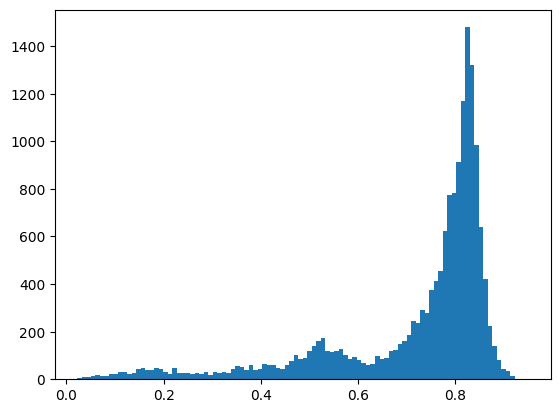

In [23]:
plt.hist(photoZ_target, bins=100)

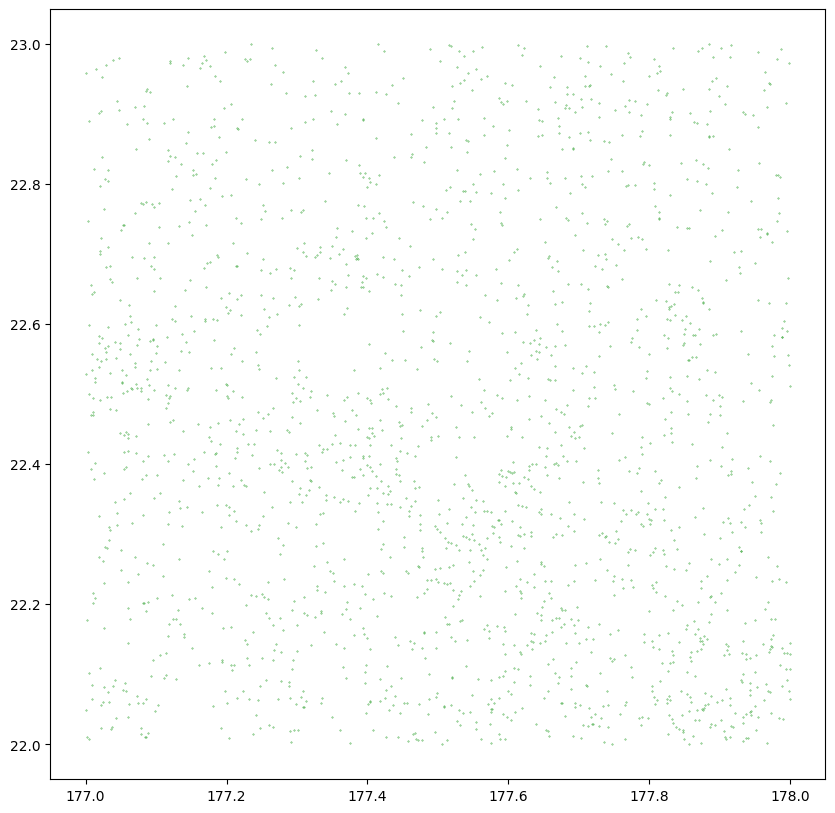

In [24]:
#Spot a knee in the photoZ distribution at around photoZ = 0.5
redshift_slice = np.where((photoZ_target > 0.4) & (photoZ_target < 0.6))
plt.figure(figsize=(10,10))
plt.scatter(ra_target[redshift_slice], dec_target[redshift_slice], s=0.1, color='C2')

# Using linear regression

In [25]:
# now we use linear regression to fit the photoZ_target
from sklearn.linear_model import LinearRegression

(array([2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 5.000e+00, 9.000e+00, 8.000e+00,
        1.000e+01, 1.400e+01, 2.500e+01, 3.000e+01, 3.500e+01, 5.200e+01,
        6.700e+01, 1.060e+02, 9.500e+01, 1.260e+02, 1.390e+02, 1.910e+02,
        2.160e+02, 2.920e+02, 3.150e+02, 4.220e+02, 4.880e+02, 6.430e+02,
        7.230e+02, 7.610e+02, 8.850e+02, 1.079e+03, 1.220e+03, 1.328e+03,
        1.326e+03, 1.317e+03, 1.159e+03, 8.750e+02, 5.580e+02, 3.490e+02,
        2.200e+02, 1.990e+02, 1.800e+02, 1.700e+02, 1.660e+02, 1.440e+02,
        9.300e+01, 7.600e+01, 4.800e+01, 5.500e+01, 4.000e+01, 4.400e+01,
        2.700e+01, 3.900e+01, 2.000e+0

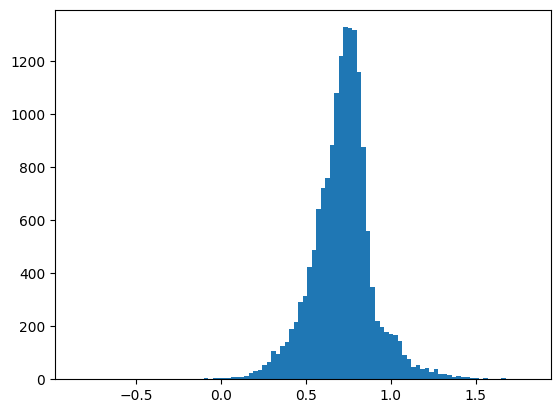

In [26]:
clf = LinearRegression()
clf.fit(petro_mag_train, specz_train)

photoZ_target = clf.predict(petro_mag_target)
plt.hist(photoZ_target, bins=100)


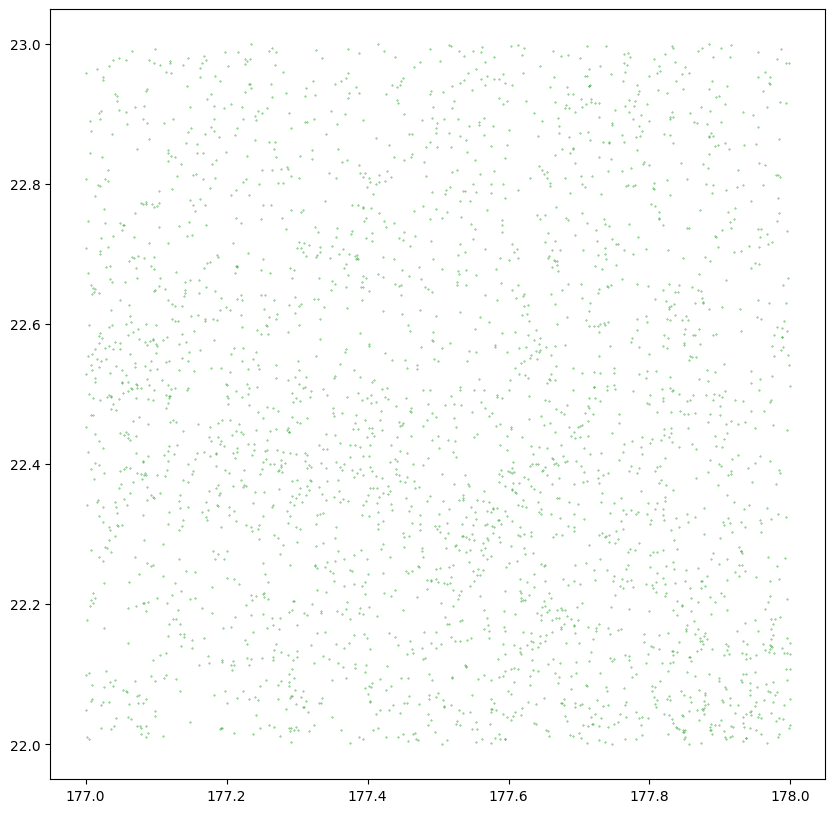

In [27]:
#Spot a knee in the photoZ distribution at around photoZ = 0.5
redshift_slice = np.where((photoZ_target > 0.4) & (photoZ_target < 0.6))
plt.figure(figsize=(10,10))
plt.scatter(ra_target[redshift_slice], dec_target[redshift_slice], s=0.1, color='C2')

#**Block 7.5: Extra, extra!**
With all the extra parameters already downloaded, what would be a better dataset used in the training part to improve the efficiency in predicting photoZ of this algorithm?


In [28]:
# If you want more, try the algorithm again, but this time change the dataset from petro_magnitudes to something like colors; radii; surface brightness; or the combination of all.
# Keep in mind, the more parameters used, the longer it took to run.

# change the dataset to the combination of all 
petro_mag_sample = np.transpose(np.array([up, gp, rp, ip, zp, rad_up, rad_gp, rad_rp, rad_ip, rad_zp]))
specz_train = specz

print()
print(specz_train.shape, petro_mag_sample.shape)
